In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import math

SMALL_SIZE = 13
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
# plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
# plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
# plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
# plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
# plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

line_markers = ['-.','-,','-o','-v','-^','-<','->','-1','-2','-3','-4','-s','-p','-*','-h','-H','-+','-x','-D','-d','-|','-_']
line_markers = ['*','h','<','4','x','d','|','_']


%matplotlib inline

import sys
sys.path.append('../')
from core.networks import BayesianNetwork as BN
from bayes_layer import BayesianLinear
from bayes_layer import _calculate_fan_in_and_fan_out

In [2]:
def weight_node_wise_histogram(model_name, task_num=10, notMNIST=False):
    cnt = 0
    sample_num = [100,100,10]
    
    layer_size = 2
    taskcla = [(0, 10), (1, 10), (2, 10), (3, 10), (4, 10), (5, 10), (6, 10), (7, 10), (8, 10), (9, 10), (10, 10), (11, 10), (12, 10), (13, 10), (14, 10), (15, 10), (16, 10), (17, 10), (18, 10), (19, 10)]
    split=False
    if notMNIST:
        split=True
        taskcla = [(0, 2), (1, 2), (2, 2), (3, 2), (4, 2)]
        task_num = 5
        layer_size = 4
    
    model = BN((1,28,28),taskcla,split=split, notMNIST = notMNIST)
    rand_std = []
    for (_, layer) in model.named_children():
        if isinstance(layer, BayesianLinear) == False:
            continue
        std_arr = np.zeros((sample_num[cnt], task_num+1))
        out_features = layer.weight_rho.shape[0]
        rand_idx = np.arange(out_features)
        np.random.shuffle(rand_idx)
        rand_idx = np.sort(rand_idx[:sample_num[cnt]])
        
        fan_in, fan_out = _calculate_fan_in_and_fan_out(layer.weight_mu)
        gain = math.sqrt(1.0)
        std_init = gain / math.sqrt(fan_in)
        
        std_arr[:,0] = np.ones(sample_num[cnt]) * std_init
        for t in range(task_num):
            model.load_state_dict(torch.load(model_name%t))
            
            std = np.log(1+np.exp(layer.weight_rho.data.cpu().numpy())).reshape((out_features))
            std = np.sort(std)
            std_arr[:,t+1] = std[rand_idx]
            
        reg_arr = (std_init/std_arr)**2
        rand_std.append(std_arr)
#         rand_std.append(reg_arr)
        cnt += 1
        
    
    plt.figure(figsize=(15,15))
    for l in range(cnt):
        plt.subplot(3,1,l+1)
#         plt.figure(figsize=(15,5))
        
        for i in range(sample_num[l]):
            plt.plot(np.arange(task_num+1), rand_std[l][i], linestyle = '-')

        fontsize = 20
        plt.xticks(np.arange(task_num+1),fontsize = fontsize)
        plt.yticks(fontsize = 15)

        plt.xlabel('Task', fontsize = fontsize)
#         plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = fontsize)
        if l==0:
            plt.ylabel('STD',fontsize = fontsize)
#             plt.ylabel('Strength',fontsize = fontsize)
#         plt.ylim(0,0.4)
#         plt.yticks([0.0,0.1,0.2,0.3,0.4], fontsize = fontsize)
        plt.title('Layer %d'%(l+1), fontsize = fontsize)
        plt.tight_layout()

#     plt.savefig('figure/histogram_layer.pdf', bbox_inches='tight')

In [3]:
def avg_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    avg_acc_arr = np.zeros(tasknum)
    for i in range(tasknum):
        avg_acc_arr[i] = np.mean(acc_arr[i][:i+1])
    
    return avg_acc_arr

In [4]:
def test_acc(file_name, tasknum = 10):
    acc_arr = np.zeros((tasknum,tasknum))
    with open(file_name, 'r') as f:
        data = f.read().splitlines()
        for i in range(len(data)):
            arr = data[i].split()
            for j in range(tasknum):
                acc_arr[i][j] = arr[j]
    return acc_arr

In [5]:
UCL = {}
m_arr = ['no_L1', 'no_normal', 'no_output', 'original', 'no_min', 'SKKU']
for m in m_arr:
    UCL[m] = {}
UCL['SKKU'][0] = 'SKKU_pmnist_baye_0_beta_0.0300000_unitN_400_batch_256_epoch_100_0.0600152.txt'
UCL['no_L1'][2] = 'RESULT_no_L1_pmnist_baye_2_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_L1'][3] = 'RESULT_no_L1_pmnist_baye_3_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_L1'][4] = 'RESULT_no_L1_pmnist_baye_4_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_L1'][7] = 'RESULT_no_L1_pmnist_baye_7_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_L1'][9] = 'RESULT_no_L1_pmnist_baye_9_beta_0.03_unitN_400_batch_256_epoch_100.txt'

UCL['no_normal'][2] = 'RESULT_no_normal_pmnist_baye_2_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_normal'][3] = 'RESULT_no_normal_pmnist_baye_3_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_normal'][4] = 'RESULT_no_normal_pmnist_baye_4_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_normal'][7] = 'RESULT_no_normal_pmnist_baye_7_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_normal'][9] = 'RESULT_no_normal_pmnist_baye_9_beta_0.03_unitN_400_batch_256_epoch_100.txt'

UCL['no_output'][2] = 'RESULT_no_output_pmnist_baye_2_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_output'][3] = 'RESULT_no_output_pmnist_baye_3_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_output'][4] = 'RESULT_no_output_pmnist_baye_4_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_output'][7] = 'RESULT_no_output_pmnist_baye_7_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_output'][9] = 'RESULT_no_output_pmnist_baye_9_beta_0.03_unitN_400_batch_256_epoch_100.txt'

UCL['original'][2] = 'RESULT_pmnist_baye_2_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['original'][3] = 'RESULT_pmnist_baye_3_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['original'][4] = 'RESULT_pmnist_baye_4_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['original'][7] = 'RESULT_pmnist_baye_7_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['original'][9] = 'RESULT_pmnist_baye_9_beta_0.03_unitN_400_batch_256_epoch_100.txt'

UCL['no_min'][2] = 'RESULT_no_min_pmnist_baye_2_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_min'][3] = 'RESULT_no_min_pmnist_baye_3_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_min'][4] = 'RESULT_no_min_pmnist_baye_4_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_min'][7] = 'RESULT_no_min_pmnist_baye_7_beta_0.03_unitN_400_batch_256_epoch_100.txt'
UCL['no_min'][9] = 'RESULT_no_min_pmnist_baye_9_beta_0.03_unitN_400_batch_256_epoch_100.txt'



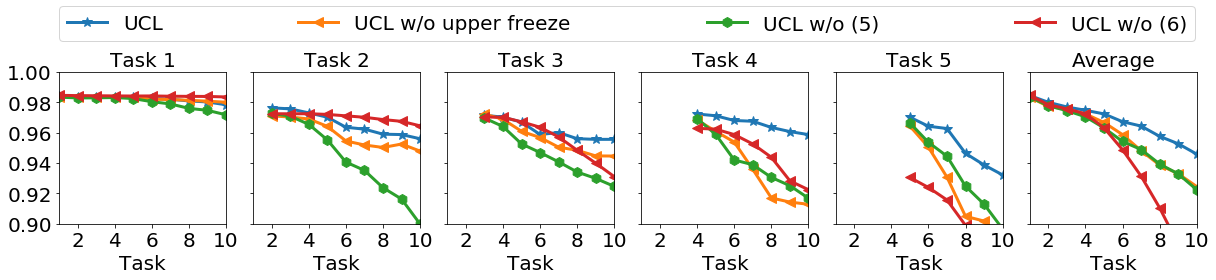

In [6]:
UCL_original = (test_acc(UCL['original'][2],tasknum=10)+test_acc(UCL['original'][3],tasknum=10)+test_acc(UCL['original'][4],tasknum=10)+test_acc(UCL['original'][7],tasknum=10)+test_acc(UCL['original'][9],tasknum=10))/5
UCL_no_L1 = (test_acc(UCL['no_L1'][2],tasknum=10)+test_acc(UCL['no_L1'][3],tasknum=10)+test_acc(UCL['no_L1'][4],tasknum=10)+test_acc(UCL['no_L1'][7],tasknum=10)+test_acc(UCL['no_L1'][9],tasknum=10))/5
UCL_no_normal = (test_acc(UCL['no_normal'][2],tasknum=10)+test_acc(UCL['no_normal'][3],tasknum=10)+test_acc(UCL['no_normal'][4],tasknum=10)+test_acc(UCL['no_normal'][7],tasknum=10)+test_acc(UCL['no_normal'][9],tasknum=10))/5
UCL_no_min = (test_acc(UCL['no_min'][2],tasknum=10)+test_acc(UCL['no_min'][3],tasknum=10)+test_acc(UCL['no_min'][4],tasknum=10)+test_acc(UCL['no_min'][7],tasknum=10)+test_acc(UCL['no_min'][9],tasknum=10))/5
# UCL_no_output = (test_acc(UCL['no_output'][2],tasknum=10)+test_acc(UCL['no_output'][3],tasknum=10)+test_acc(UCL['no_output'][4],tasknum=10)+test_acc(UCL['no_output'][7],tasknum=10)+test_acc(UCL['no_output'][9],tasknum=10))/5
# UCL_SKKU = test_acc(UCL['SKKU'][0],tasknum=10)
task = np.arange(10)+1

plt.figure(figsize = (17,4))
for i in range(5):
    plt.subplot(1,6,i+1)
    
#     plt.plot(task[i:], UCL_SKKU[i:,i], label = 'Ours', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10, color = '#bcbd22')
    
    plt.plot(task[i:], UCL_original[i:,i], label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
    plt.plot(task[i:], UCL_no_min[i:,i], label = 'UCL w/o upper freeze', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
    plt.plot(task[i:], UCL_no_L1[i:,i], label = 'UCL w/o (5)', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
    plt.plot(task[i:], UCL_no_normal[i:,i], label = 'UCL w/o (6)', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
#     plt.plot(task[i:], UCL_no_output[i:,i], label = 'UCL w/o output uncertainty', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
    plt.xlim(1,10)
    plt.xticks([2,4,6,8,10], fontsize = 20)
    plt.ylim(0.9,1.0)
    if i==0:
        plt.legend(bbox_to_anchor=(0, 1.2, 6.8,.102), loc=3, ncol=4, mode='expand', borderaxespad=0., frameon = True, fontsize = 20)
    visible = True
    if i>0:
        visible=False
    plt.ylim(0.9,1.0)
    plt.yticks([0.90,0.92,0.94,0.96,0.98,1.0], fontsize = 20, visible=visible)
    plt.xlabel('Task', fontsize=20)
    plt.title('Task %d'%(i+1), fontsize = 20)
    plt.tight_layout()
    
# UCL_SKKU = avg_acc(UCL['SKKU'][0])
UCL_no_L1 = (avg_acc(UCL['no_L1'][2])+avg_acc(UCL['no_L1'][3])+avg_acc(UCL['no_L1'][4])+avg_acc(UCL['no_L1'][7])+avg_acc(UCL['no_L1'][9]))/5
UCL_no_normal = (avg_acc(UCL['no_normal'][2])+avg_acc(UCL['no_normal'][3])+avg_acc(UCL['no_normal'][4])+avg_acc(UCL['no_normal'][7])+avg_acc(UCL['no_normal'][9]))/5
UCL_no_min = (avg_acc(UCL['no_min'][2])+avg_acc(UCL['no_min'][3])+avg_acc(UCL['no_min'][4])+avg_acc(UCL['no_min'][7])+avg_acc(UCL['no_min'][9]))/5
# UCL_no_output = (avg_acc(UCL['no_output'][2])+avg_acc(UCL['no_output'][3])+avg_acc(UCL['no_output'][4])+avg_acc(UCL['no_output'][7])+avg_acc(UCL['no_output'][9]))/5
UCL_original = (avg_acc(UCL['original'][2])+avg_acc(UCL['original'][3])+avg_acc(UCL['original'][4])+avg_acc(UCL['original'][7])+avg_acc(UCL['original'][9]))/5

plt.subplot(1,6,6)
# plt.plot(task, UCL_SKKU, label = 'Ours', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10, color = '#bcbd22')
plt.plot(task, UCL_original, label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, UCL_no_min, label = 'w/o upper freeze', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
plt.plot(task, UCL_no_L1, label = 'w/o (5)', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
plt.plot(task, UCL_no_normal, label = 'w/o (6)', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
# plt.plot(task, UCL_no_output, label = 'w/o output noise', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
plt.xlim(1,10)
plt.xticks([2,4,6,8,10], fontsize = 20)
plt.ylim(0.9,1.0)
plt.yticks([0.90,0.92,0.94,0.96,0.98,1.0], fontsize = 20, visible=visible)
plt.title('Average', fontsize = 20)
plt.xlabel('Task',fontsize = 20)

plt.tight_layout()
# plt.savefig('figure/Ablation_PMNIST_per_task_avg.pdf', bbox_inches='tight')

In [7]:
UCL = {}
EWC = {}
SI = {}
HAT = {}
VCL = {}
VCL_coreset = {}

for experiment in ['pmnist', 'row_pmnist', 'split_mnist','split_notmnist','split_pmnist','split_row_pmnist']:
    UCL[experiment] = {}
    EWC[experiment] = {}
    SI[experiment] = {}
    HAT[experiment] = {}
    VCL[experiment] = {}
    VCL_coreset[experiment] = {}

In [8]:
seed_arr = [0,1,4,6,10]
for seed in seed_arr:
    UCL['row_pmnist'][seed] = 'RESULT_row_pmnist_baye_%d_beta_0.02_unitN_400_batch_256_epoch_100.txt'%seed

seed_arr = [2,3,4,7,9]


for seed in seed_arr:
    
    UCL['pmnist'][seed] = 'RESULT_pmnist_baye_%d_beta_0.03_unitN_400_batch_256_epoch_100.txt'%seed
#     UCL['row_pmnist'][seed] = 'RESULT_row_pmnist_baye_%d_beta_0.02_unitN_400_batch_256_epoch_100.txt'%seed
    UCL['split_mnist'][seed] = 'RESULT_split_mnist_baye_%d_beta_0.0001_unitN_256_batch_256_epoch_100.txt'%seed
    UCL['split_notmnist'][seed] = 'RESULT_split_notmnist_baye_%d_beta_0.001_unitN_150_batch_256_epoch_100.txt'%seed
    UCL['split_pmnist'][seed] = 'RESULT_split_pmnist_baye_%d_beta_0.03_unitN_400_batch_256_epoch_100.txt'%seed
    UCL['split_row_pmnist'][seed] = 'RESULT_split_row_pmnist_baye_%d_beta_0.02_unitN_400_batch_256_epoch_100.txt'%seed

    EWC['pmnist'][seed] = 'RESULT_pmnist_ewc_with_log_%d_lamb_400.0_unitN_400_batch_256_epoch_100.txt'%seed
    EWC['row_pmnist'][seed] = 'RESULT_row_pmnist_ewc_with_log_%d_lamb_400.0_unitN_400_batch_256_epoch_100.txt'%seed
    EWC['split_mnist'][seed] = 'RESULT_split_mnist_ewc_with_log_%d_lamb_4000.0_unitN_256_batch_256_epoch_100.txt'%seed
    EWC['split_notmnist'][seed] = 'RESULT_split_notmnist_ewc_with_log_%d_lamb_4000.0_unitN_150_batch_256_epoch_100.txt'%seed
    EWC['split_pmnist'][seed] = 'RESULT_split_pmnist_ewc_with_log_%d_lamb_400.0_unitN_400_batch_256_epoch_100.txt'%seed
    EWC['split_row_pmnist'][seed] = 'RESULT_split_row_pmnist_ewc_with_log_%d_lamb_4000.0_unitN_400_batch_256_epoch_100.txt'%seed

    SI['pmnist'][seed] = 'RESULT_pmnist_si_with_log_%d_c_0.03_unitN_400_batch_256_epoch_100.txt'%seed
    SI['row_pmnist'][seed] = 'RESULT_row_pmnist_si_with_log_%d_c_0.03_unitN_400_batch_256_epoch_100.txt'%seed
    SI['split_mnist'][seed] = 'RESULT_split_mnist_si_with_log_%d_c_1.0_unitN_256_batch_256_epoch_100.txt'%seed
    SI['split_notmnist'][seed] = 'RESULT_split_notmnist_si_with_log_%d_c_0.3_unitN_150_batch_256_epoch_100.txt'%seed
    SI['split_pmnist'][seed] = 'RESULT_split_pmnist_si_with_log_%d_c_0.03_unitN_400_batch_256_epoch_100.txt'%seed
    SI['split_row_pmnist'][seed] = 'RESULT_split_row_pmnist_si_with_log_%d_c_0.03_unitN_400_batch_256_epoch_100.txt'%seed
    
    HAT['pmnist'][seed] = 'RESULT_pmnist_hat_%d_alpha_0.75_unitN_400_batch_256_epoch_100.txt'%seed
    HAT['row_pmnist'][seed] = 'RESULT_row_pmnist_hat_%d_alpha_0.75_unitN_400_batch_256_epoch_100.txt'%seed
    HAT['split_mnist'][seed] = 'RESULT_split_mnist_hat_%d_alpha_0.75_unitN_256_batch_256_epoch_100.txt'%seed
    HAT['split_notmnist'][seed] = 'RESULT_split_notmnist_hat_%d_alpha_0.75_unitN_150_batch_256_epoch_100.txt'%seed
    HAT['split_pmnist'][seed] = 'RESULT_split_pmnist_hat_%d_alpha_0.75_unitN_400_batch_256_epoch_100.txt'%seed
    HAT['split_row_pmnist'][seed] = 'RESULT_split_row_pmnist_hat_%d_alpha_0.75_unitN_400_batch_256_epoch_100.txt'%seed\
    
    VCL['pmnist'][seed] = 'RESULT_pmnist_vcl_%d_unitN_400_batch_256_epoch_200.txt'%seed
    VCL['row_pmnist'][seed] = 'RESULT_row_pmnist_vcl_%d_unitN_400_batch_256_epoch_200.txt'%seed
    VCL['split_mnist'][seed] = 'RESULT_split_mnist_vcl_%d_unitN_256_batch_256_epoch_120.txt'%seed
    VCL['split_notmnist'][seed] = 'RESULT_split_notmnist_vcl_%d_unitN_150_batch_256_epoch_120.txt'%seed
    VCL['split_pmnist'][seed] = 'RESULT_split_pmnist_vcl_%d_unitN_400_batch_256_epoch_200.txt'%seed
    VCL['split_row_pmnist'][seed] = 'RESULT_split_row_pmnist_vcl_%d_unitN_400_batch_256_epoch_200.txt'%seed
    
    VCL_coreset['pmnist'][seed] = 'RESULT_pmnist_vcl_coreset_%d_unitN_400_batch_256_epoch_200.txt'%seed
    VCL_coreset['row_pmnist'][seed] = 'RESULT_row_pmnist_vcl_coreset_%d_unitN_400_batch_256_epoch_200.txt'%seed
    VCL_coreset['split_mnist'][seed] = 'RESULT_split_mnist_vcl_coreset_%d_unitN_256_batch_256_epoch_120.txt'%seed
    VCL_coreset['split_notmnist'][seed] = 'RESULT_split_notmnist_vcl_coreset_%d_unitN_150_batch_256_epoch_120.txt'%seed
    VCL_coreset['split_pmnist'][seed] = 'RESULT_split_pmnist_vcl_coreset_%d_unitN_400_batch_256_epoch_200.txt'%seed
    VCL_coreset['split_row_pmnist'][seed] = 'RESULT_split_row_pmnist_vcl_coreset_%d_unitN_400_batch_256_epoch_200.txt'%seed

In [9]:
he_zero = {}
beta_arr = [0.02,0.025,0.03,0.035,0.04,0.045,0.05]
for beta in beta_arr:
    he_zero[beta] = np.zeros((10,20))
    for seed in range(10):
        name = '190725_ZERO_pmnist_baye_{}_beta_{:.7f}_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100.txt'
        he_zero[beta][seed] = avg_acc(name.format(seed,beta), tasknum=20)


[0.9865     0.98145    0.97826667 0.9777     0.97588    0.9734
 0.9711     0.9680375  0.96523333 0.96116   ]
[0.9858     0.97995    0.9781     0.97595    0.97512    0.97288333
 0.96988571 0.9679375  0.96035556 0.95863   ]
[0.9865     0.98165    0.9793     0.977325   0.97502    0.97125
 0.96831429 0.9655875  0.96262222 0.95817   ]
[0.986      0.9807     0.9784     0.97625    0.97434    0.97148333
 0.96864286 0.9631     0.95573333 0.95098   ]


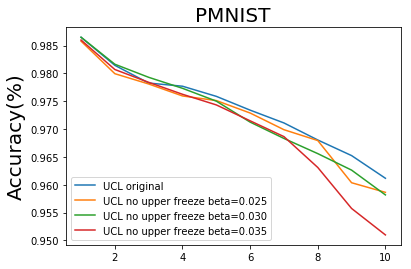

In [10]:

tasknum = 10


test_25 = avg_acc('TEST_pmnist_baye_0_beta_0.0250000_FC_0.5000000_CNN_0.2500000_lr_0.001_unitN_400_batch_256_epoch_100.txt')
test_30 = avg_acc('TEST_pmnist_baye_0_beta_0.0300000_FC_0.5000000_CNN_0.2500000_lr_0.001_unitN_400_batch_256_epoch_100.txt')
test_35 = avg_acc('TEST_pmnist_baye_0_beta_0.0350000_FC_0.5000000_CNN_0.2500000_lr_0.001_unitN_400_batch_256_epoch_100.txt')

task = np.arange(tasknum) + 1

plt.figure()

# plt.errorbar(task, np.mean(he_zero[0.020], axis = 0), np.std(he_zero[0.020], axis = 0), linestyle='-', label=r'UCL $\beta$=0.020')
# plt.errorbar(task, np.mean(he_zero[0.025], axis = 0), np.std(he_zero[0.025], axis = 0), linestyle='-', label=r'UCL $\beta$=0.025')
# plt.errorbar(task, np.mean(he_zero[0.030], axis = 0), np.std(he_zero[0.030], axis = 0), linestyle='-', label=r'UCL $\beta$=0.030')
# plt.errorbar(task, np.mean(he_zero[0.035], axis = 0)[:10], np.std(he_zero[0.035], axis = 0)[:10], linestyle='-', label=r'UCL $\beta$=0.035')
# plt.errorbar(task, np.mean(he_zero[0.040], axis = 0), np.std(he_zero[0.040], axis = 0), linestyle='-', label=r'UCL $\beta$=0.040')
# plt.errorbar(task, np.mean(he_zero[0.045], axis = 0), np.std(he_zero[0.045], axis = 0), linestyle='-', label=r'UCL $\beta$=0.045')
# plt.errorbar(task, np.mean(he_zero[0.050], axis = 0), np.std(he_zero[0.050], axis = 0), linestyle='-', label=r'UCL $\beta$=0.050')
plt.plot(task, he_zero[0.035][0][:10], linestyle='-', label=r'UCL original')
plt.plot(task, test_25, linestyle='-', label=r'UCL no upper freeze beta=0.025')
plt.plot(task, test_30, linestyle='-', label=r'UCL no upper freeze beta=0.030')
plt.plot(task, test_35, linestyle='-', label=r'UCL no upper freeze beta=0.035')


# plt.xticks([6,7,8,9,10], fontsize = 20)

# plt.ylim(0.9,1.0)
# plt.yticks([0.9,0.92,0.94,0.96,0.98,1.0], fontsize = 20)

plt.ylabel('Accuracy(%)', fontsize = 20)

plt.legend(loc = 'lower left')
plt.title('PMNIST', fontsize = 20)

print(he_zero[0.035][0][:10])
print(test_25)
print(test_30)
print(test_35)

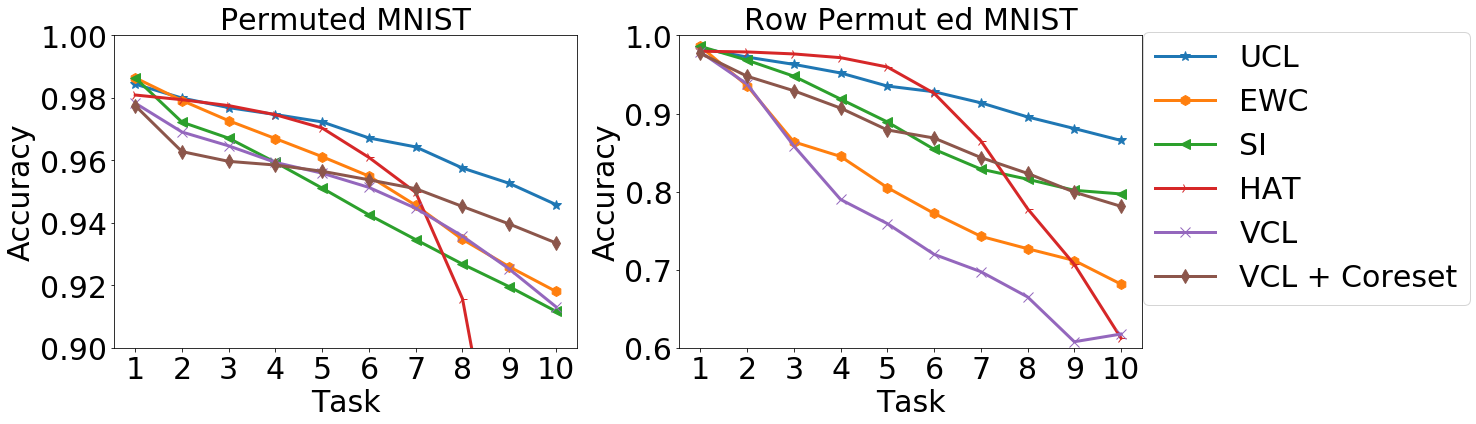

In [11]:
"""
pmnist
row_pmnist
"""
fontsize = 30
UCL_plot = (avg_acc(UCL['pmnist'][2])+avg_acc(UCL['pmnist'][3])+avg_acc(UCL['pmnist'][4])+avg_acc(UCL['pmnist'][7])+avg_acc(UCL['pmnist'][9]))/5
EWC_plot = (avg_acc(EWC['pmnist'][2])+avg_acc(EWC['pmnist'][3])+avg_acc(EWC['pmnist'][4])+avg_acc(EWC['pmnist'][7])+avg_acc(EWC['pmnist'][9]))/5
SI_plot = (avg_acc(SI['pmnist'][2])+avg_acc(SI['pmnist'][3])+avg_acc(SI['pmnist'][4])+avg_acc(SI['pmnist'][7])+avg_acc(SI['pmnist'][9]))/5
HAT_plot = (avg_acc(HAT['pmnist'][2])+avg_acc(HAT['pmnist'][3])+avg_acc(HAT['pmnist'][4])+avg_acc(HAT['pmnist'][7])+avg_acc(HAT['pmnist'][9]))/5
VCL_plot = (avg_acc(VCL['pmnist'][2])+avg_acc(VCL['pmnist'][3])+avg_acc(VCL['pmnist'][4])+avg_acc(VCL['pmnist'][7])+avg_acc(VCL['pmnist'][9]))/5
VCL_coreset_plot = (avg_acc(VCL_coreset['pmnist'][2])+avg_acc(VCL_coreset['pmnist'][3])+avg_acc(VCL_coreset['pmnist'][4])+avg_acc(VCL_coreset['pmnist'][7])+avg_acc(VCL_coreset['pmnist'][9]))/5

task = np.arange(10) + 1

plt.figure(figsize=(24,6))
plt.subplot(121)
plt.plot(task, UCL_plot, label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, EWC_plot, label = 'EWC', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
plt.plot(task, SI_plot, label = 'SI', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
plt.plot(task, HAT_plot, label = 'HAT', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
plt.plot(task, VCL_plot, label = 'VCL', linestyle = '-', marker = line_markers[4], linewidth=3, markersize=10)
plt.plot(task, VCL_coreset_plot, label = 'VCL + Coreset', linestyle = '-', marker = line_markers[5], linewidth=3, markersize=10)

plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = fontsize)

plt.ylim(0.6,1.0)
plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.ylim(0.9,1.0)
plt.yticks([0.9,0.92,0.94,0.96,0.98,1.0], fontsize = fontsize)

plt.xlabel('Task',fontsize = fontsize)
plt.ylabel('Accuracy',fontsize = fontsize)
plt.title('Permuted MNIST', fontsize = fontsize)
# plt.legend(loc = 'lower left', frameon = True, fontsize = 20)
# plt.legend(bbox_to_anchor=(0, 1.1, 2.23,.102), loc=3, ncol=3, mode='expand', borderaxespad=0., frameon = True, fontsize = 20)
plt.tight_layout()
# plt.grid(color='black', linestyle=':', linewidth=0.01)

# print('pmnist_single')
# print('UCL')
# print(UCL_plot)
# print('EWC')
# print(EWC_plot)
# print('SI')
# print(SI_plot)
# print('HAT')
# print(HAT_plot)
# print('VCL')
# print(VCL_plot)
# print('VCL + Coreset')
# print(VCL_coreset_plot)

# UCL_plot = (avg_acc(UCL['row_pmnist'][2])+avg_acc(UCL['row_pmnist'][3])+avg_acc(UCL['row_pmnist'][4])+avg_acc(UCL['row_pmnist'][7])+avg_acc(UCL['row_pmnist'][9]))/5
UCL_plot = (avg_acc(UCL['row_pmnist'][0])+avg_acc(UCL['row_pmnist'][1])+avg_acc(UCL['row_pmnist'][4])+avg_acc(UCL['row_pmnist'][6])+avg_acc(UCL['row_pmnist'][10]))/5
EWC_plot = (avg_acc(EWC['row_pmnist'][2])+avg_acc(EWC['row_pmnist'][3])+avg_acc(EWC['row_pmnist'][4])+avg_acc(EWC['row_pmnist'][7])+avg_acc(EWC['row_pmnist'][9]))/5
SI_plot = (avg_acc(SI['row_pmnist'][2])+avg_acc(SI['row_pmnist'][3])+avg_acc(SI['row_pmnist'][4])+avg_acc(SI['row_pmnist'][7])+avg_acc(SI['row_pmnist'][9]))/5
HAT_plot = (avg_acc(HAT['row_pmnist'][2])+avg_acc(HAT['row_pmnist'][3])+avg_acc(HAT['row_pmnist'][4])+avg_acc(HAT['row_pmnist'][7])+avg_acc(HAT['row_pmnist'][9]))/5
VCL_plot = (avg_acc(VCL['row_pmnist'][2])+avg_acc(VCL['row_pmnist'][3])+avg_acc(VCL['row_pmnist'][4])+avg_acc(VCL['row_pmnist'][7])+avg_acc(VCL['row_pmnist'][9]))/5
VCL_coreset_plot = (avg_acc(VCL_coreset['row_pmnist'][2])+avg_acc(VCL_coreset['row_pmnist'][3])+avg_acc(VCL_coreset['row_pmnist'][4])+avg_acc(VCL_coreset['row_pmnist'][7])+avg_acc(VCL_coreset['row_pmnist'][9]))/5

plt.subplot(122)
plt.plot(task, UCL_plot, label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, EWC_plot, label = 'EWC', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
plt.plot(task, SI_plot, label = 'SI', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
plt.plot(task, HAT_plot, label = 'HAT', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
plt.plot(task, VCL_plot, label = 'VCL', linestyle = '-', marker = line_markers[4], linewidth=3, markersize=10)
plt.plot(task, VCL_coreset_plot, label = 'VCL + Coreset', linestyle = '-', marker = line_markers[5], linewidth=3, markersize=10)

plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize = fontsize)

plt.ylim(0.6,1.0)
plt.yticks([0.60,0.70,0.80,0.90,1.00], fontsize = fontsize)

plt.xlabel('Task',fontsize = fontsize)
plt.ylabel('Accuracy',fontsize = fontsize)
plt.title('Row Permut ed MNIST', fontsize = fontsize)
# plt.legend(bbox_to_anchor=(1.45, 0.8), loc='upper center', ncol=1, mode='expand', borderaxespad=0., frameon = True, fontsize = 20)
plt.legend(bbox_to_anchor=(1.74, 1.06), loc='upper right', ncol=1, fontsize = 30)
# plt.grid(color='black', linestyle=':', linewidth=0.01)
plt.tight_layout()
plt.savefig('figure/single_PMNIST.pdf', bbox_inches='tight')

# print('row_pmnist_single')
# print('UCL')
# print(UCL_plot)
# print('EWC')
# print(EWC_plot)
# print('SI')
# print(SI_plot)
# print('HAT')
# print(HAT_plot)
# print('VCL')
# print(VCL_plot)
# print('VCL + Coreset')
# print(VCL_coreset_plot)

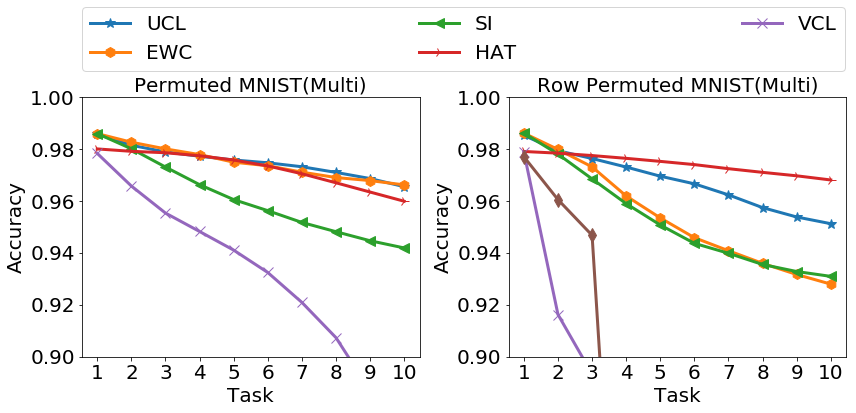

In [12]:
"""
split_pmnist
split_row_pmnist
"""

UCL_plot = (avg_acc(UCL['split_pmnist'][2])+avg_acc(UCL['split_pmnist'][3])+avg_acc(UCL['split_pmnist'][4])+avg_acc(UCL['split_pmnist'][7])+avg_acc(UCL['split_pmnist'][9]))/5
EWC_plot = (avg_acc(EWC['split_pmnist'][2])+avg_acc(EWC['split_pmnist'][3])+avg_acc(EWC['split_pmnist'][4])+avg_acc(EWC['split_pmnist'][7])+avg_acc(EWC['split_pmnist'][9]))/5
SI_plot = (avg_acc(SI['split_pmnist'][2])+avg_acc(SI['split_pmnist'][3])+avg_acc(SI['split_pmnist'][4])+avg_acc(SI['split_pmnist'][7])+avg_acc(SI['split_pmnist'][9]))/5
HAT_plot = (avg_acc(HAT['split_pmnist'][2])+avg_acc(HAT['split_pmnist'][3])+avg_acc(HAT['split_pmnist'][4])+avg_acc(HAT['split_pmnist'][7])+avg_acc(HAT['split_pmnist'][9]))/5
VCL_plot = (avg_acc(VCL['split_pmnist'][2])+avg_acc(VCL['split_pmnist'][3])+avg_acc(VCL['split_pmnist'][4])+avg_acc(VCL['split_pmnist'][7])+avg_acc(VCL['split_pmnist'][9]))/5
# VCL_coreset_plot = (avg_acc(VCL_coreset['split_pmnist'][2])+avg_acc(VCL_coreset['split_pmnist'][3])+avg_acc(VCL_coreset['split_pmnist'][4])+avg_acc(VCL_coreset['split_pmnist'][7])+avg_acc(VCL_coreset['split_pmnist'][9]))/5

task = np.arange(10) + 1

plt.figure(figsize=(12,6))
plt.subplot(121)
# plt.figure()
plt.plot(task, UCL_plot, label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, EWC_plot, label = 'EWC', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
plt.plot(task, SI_plot, label = 'SI', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
plt.plot(task, HAT_plot, label = 'HAT', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
plt.plot(task, VCL_plot, label = 'VCL', linestyle = '-', marker = line_markers[4], linewidth=3, markersize=10)
# plt.plot(task, VCL_coreset_plot, label = 'VCL + Random Coreset', linestyle = '-', marker = line_markers[5], linewidth=3, markersize=10)

plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize=20)

# plt.ylim(0.6,1.0)
# plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.ylim(0.9,1.0)
plt.yticks([0.9,0.92,0.94,0.96,0.98,1.0], fontsize=20)


plt.tight_layout()

plt.xlabel('Task',fontsize = 20)
plt.ylabel('Accuracy',fontsize = 20)
plt.title('Permuted MNIST(Multi)', fontsize = 20)
plt.legend(bbox_to_anchor=(0, 1.1, 2.26,.102), loc=3, ncol=3, mode='expand', borderaxespad=0., frameon = True, fontsize = 20)
# plt.legend(loc = 'lower left', frameon = True, fontsize = 20)
# plt.grid(color='black', linestyle=':', linewidth=0.01)

# print('pmnist_multi')
# print('UCL')
# print(UCL_plot)
# print('EWC')
# print(EWC_plot)
# print('SI')
# print(SI_plot)
# print('HAT')
# print(HAT_plot)
# print('VCL')
# print(VCL_plot)
# print('VCL + Coreset')
# print(VCL_coreset_plot)

UCL_plot = (avg_acc(UCL['split_row_pmnist'][2])+avg_acc(UCL['split_row_pmnist'][3])+avg_acc(UCL['split_row_pmnist'][4])+avg_acc(UCL['split_row_pmnist'][7])+avg_acc(UCL['split_row_pmnist'][9]))/5
EWC_plot = (avg_acc(EWC['split_row_pmnist'][2])+avg_acc(EWC['split_row_pmnist'][3])+avg_acc(EWC['split_row_pmnist'][4])+avg_acc(EWC['split_row_pmnist'][7])+avg_acc(EWC['split_row_pmnist'][9]))/5
SI_plot = (avg_acc(SI['split_row_pmnist'][2])+avg_acc(SI['split_row_pmnist'][3])+avg_acc(SI['split_row_pmnist'][4])+avg_acc(SI['split_row_pmnist'][7])+avg_acc(SI['split_row_pmnist'][9]))/5
HAT_plot = (avg_acc(HAT['split_row_pmnist'][2])+avg_acc(HAT['split_row_pmnist'][3])+avg_acc(HAT['split_row_pmnist'][4])+avg_acc(HAT['split_row_pmnist'][7])+avg_acc(HAT['split_row_pmnist'][9]))/5
VCL_plot = (avg_acc(VCL['split_row_pmnist'][2])+avg_acc(VCL['split_row_pmnist'][3])+avg_acc(VCL['split_row_pmnist'][4])+avg_acc(VCL['split_row_pmnist'][7])+avg_acc(VCL['split_row_pmnist'][9]))/5
VCL_coreset_plot = (avg_acc(VCL_coreset['split_row_pmnist'][2])+avg_acc(VCL_coreset['split_row_pmnist'][3])+avg_acc(VCL_coreset['split_row_pmnist'][4])+avg_acc(VCL_coreset['split_row_pmnist'][7])+avg_acc(VCL_coreset['split_row_pmnist'][9]))/5

plt.subplot(122)
# plt.figure()
plt.plot(task, UCL_plot, label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, EWC_plot, label = 'EWC', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
plt.plot(task, SI_plot, label = 'SI', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
plt.plot(task, HAT_plot, label = 'HAT', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
plt.plot(task, VCL_plot, label = 'VCL', linestyle = '-', marker = line_markers[4], linewidth=3, markersize=10)
plt.plot(task, VCL_coreset_plot, label = 'VCL + Random Coreset', linestyle = '-', marker = line_markers[5], linewidth=3, markersize=10)

plt.xticks([1,2,3,4,5,6,7,8,9,10], fontsize=20)

# plt.ylim(0.6,1.0)
# plt.yticks([0.6,0.7,0.8,0.9,1.0])
plt.ylim(0.9,1.0)
plt.yticks([0.9,0.92,0.94,0.96,0.98,1.0], fontsize=20)


plt.xlabel('Task',fontsize = 20)
plt.ylabel('Accuracy',fontsize = 20)
plt.title('Row Permuted MNIST(Multi)', fontsize = 20)
# plt.legend(loc = 'lower left', frameon = True, fontsize = 20)
# plt.grid(color='black', linestyle=':', linewidth=0.01)
plt.tight_layout()
plt.savefig('figure/multi_PMNIST.pdf', bbox_inches='tight')

# print('row_pmnist_multi')
# print('UCL')
# print(UCL_plot)
# print('EWC')
# print(EWC_plot)
# print('SI')
# print(SI_plot)
# print('HAT')
# print(HAT_plot)
# print('VCL')
# print(VCL_plot)
# print('VCL + Coreset')
# print(VCL_coreset_plot)

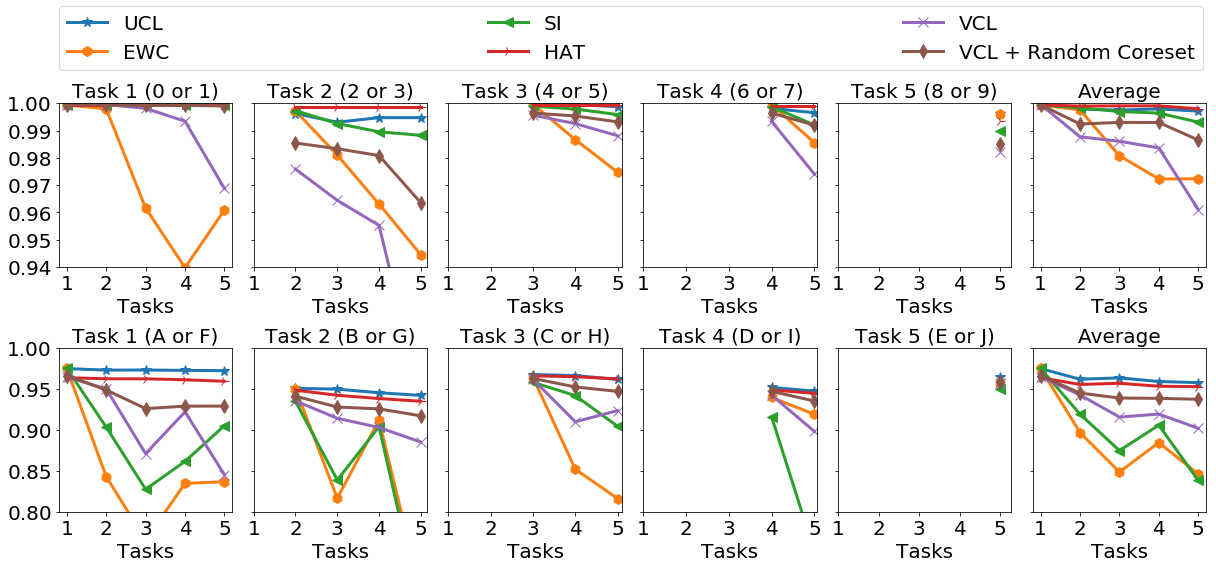

In [13]:
"""
split_mnist
split_notmnist
"""

UCL_plot = (avg_acc(UCL['split_mnist'][2],tasknum=5)+avg_acc(UCL['split_mnist'][3],tasknum=5)+avg_acc(UCL['split_mnist'][4],tasknum=5)+avg_acc(UCL['split_mnist'][7],tasknum=5)+avg_acc(UCL['split_mnist'][9],tasknum=5))/5
EWC_plot = (avg_acc(EWC['split_mnist'][2],tasknum=5)+avg_acc(EWC['split_mnist'][3],tasknum=5)+avg_acc(EWC['split_mnist'][4],tasknum=5)+avg_acc(EWC['split_mnist'][7],tasknum=5)+avg_acc(EWC['split_mnist'][9],tasknum=5))/5
SI_plot = (avg_acc(SI['split_mnist'][2],tasknum=5)+avg_acc(SI['split_mnist'][3],tasknum=5)+avg_acc(SI['split_mnist'][4],tasknum=5)+avg_acc(SI['split_mnist'][7],tasknum=5)+avg_acc(SI['split_mnist'][9],tasknum=5))/5
HAT_plot = (avg_acc(HAT['split_mnist'][2],tasknum=5)+avg_acc(HAT['split_mnist'][3],tasknum=5)+avg_acc(HAT['split_mnist'][4],tasknum=5)+avg_acc(HAT['split_mnist'][7],tasknum=5)+avg_acc(HAT['split_mnist'][9],tasknum=5))/5
VCL_plot = (avg_acc(VCL['split_mnist'][2],tasknum=5)+avg_acc(VCL['split_mnist'][3],tasknum=5)+avg_acc(VCL['split_mnist'][4],tasknum=5)+avg_acc(VCL['split_mnist'][7],tasknum=5)+avg_acc(VCL['split_mnist'][9],tasknum=5))/5
VCL_coreset_plot = (avg_acc(VCL_coreset['split_mnist'][2],tasknum=5)+avg_acc(VCL_coreset['split_mnist'][3],tasknum=5)+avg_acc(VCL_coreset['split_mnist'][4],tasknum=5)+avg_acc(VCL_coreset['split_mnist'][7],tasknum=5)+avg_acc(VCL_coreset['split_mnist'][9],tasknum=5))/5

UCL_test_plot = (test_acc(UCL['split_mnist'][2],tasknum=5)+test_acc(UCL['split_mnist'][3],tasknum=5)+test_acc(UCL['split_mnist'][4],tasknum=5)+test_acc(UCL['split_mnist'][7],tasknum=5)+test_acc(UCL['split_mnist'][9],tasknum=5))/5
EWC_test_plot = (test_acc(EWC['split_mnist'][2],tasknum=5)+test_acc(EWC['split_mnist'][3],tasknum=5)+test_acc(EWC['split_mnist'][4],tasknum=5)+test_acc(EWC['split_mnist'][7],tasknum=5)+test_acc(EWC['split_mnist'][9],tasknum=5))/5
SI_test_plot = (test_acc(SI['split_mnist'][2],tasknum=5)+test_acc(SI['split_mnist'][3],tasknum=5)+test_acc(SI['split_mnist'][4],tasknum=5)+test_acc(SI['split_mnist'][7],tasknum=5)+test_acc(SI['split_mnist'][9],tasknum=5))/5
HAT_test_plot = (test_acc(HAT['split_mnist'][2],tasknum=5)+test_acc(HAT['split_mnist'][3],tasknum=5)+test_acc(HAT['split_mnist'][4],tasknum=5)+test_acc(HAT['split_mnist'][7],tasknum=5)+test_acc(HAT['split_mnist'][9],tasknum=5))/5
VCL_test_plot = (test_acc(VCL['split_mnist'][2],tasknum=5)+test_acc(VCL['split_mnist'][3],tasknum=5)+test_acc(VCL['split_mnist'][4],tasknum=5)+test_acc(VCL['split_mnist'][7],tasknum=5)+test_acc(VCL['split_mnist'][9],tasknum=5))/5
VCL_coreset_test_plot = (test_acc(VCL_coreset['split_mnist'][2],tasknum=5)+test_acc(VCL_coreset['split_mnist'][3],tasknum=5)+test_acc(VCL_coreset['split_mnist'][4],tasknum=5)+test_acc(VCL_coreset['split_mnist'][7],tasknum=5)+test_acc(VCL_coreset['split_mnist'][9],tasknum=5))/5

task = np.arange(5) + 1

plt.figure(figsize = (17,8))
for i in range(5):
    plt.subplot(2,6,i+1)
    plt.plot(task[i:], UCL_test_plot[i:5,i], label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
    plt.plot(task[i:], EWC_test_plot[i:5,i], label = 'EWC', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
    plt.plot(task[i:], SI_test_plot[i:5,i], label = 'SI', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
    plt.plot(task[i:], HAT_test_plot[i:5,i], label = 'HAT', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
    plt.plot(task[i:], VCL_test_plot[i:5,i], label = 'VCL', linestyle = '-', marker = line_markers[4], linewidth=3, markersize=10)
    plt.plot(task[i:], VCL_coreset_test_plot[i:5,i], label = 'VCL + Random Coreset', linestyle = '-', marker = line_markers[5], linewidth=3, markersize=10)
    if i==0:
        plt.xticks([1,2,3,4,5], fontsize = 20)
        plt.ylim(0.94,1.0)
        plt.yticks([0.94,0.95,0.96,0.97,0.98,0.99,1.00], fontsize = 20)
#         plt.grid(color='black', linestyle=':', linewidth=0.01)
        plt.legend(bbox_to_anchor=(0, 1.2, 6.6,.102), loc=3, ncol=3, mode='expand', borderaxespad=0., frameon = True, fontsize = 20)
    else:
        plt.xticks([1,2,3,4,5], fontsize = 20)
        plt.ylim(0.94,1.0)
        plt.yticks([0.94,0.95,0.96,0.97,0.98,0.99,1.00], visible=False)
#         plt.grid(color='black', linestyle=':', linewidth=0.01)
    plt.xlabel('Tasks',fontsize = 20)
    plt.title('Task %d (%d or %d)'%(i+1,2*i, 2*i+1), fontsize = 20)
    plt.tight_layout()

plt.subplot(2,6,6)
plt.plot(task, UCL_plot, label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, EWC_plot, label = 'EWC', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
plt.plot(task, SI_plot, label = 'SI', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
plt.plot(task, HAT_plot, label = 'HAT', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
plt.plot(task, VCL_plot, label = 'VCL', linestyle = '-', marker = line_markers[4], linewidth=3, markersize=10)
plt.plot(task, VCL_coreset_plot, label = 'VCL + Random Coreset', linestyle = '-', marker = line_markers[5], linewidth=3, markersize=10)
plt.xticks([1,2,3,4,5], fontsize = 20)
plt.ylim(0.94,1.0)
plt.yticks([0.94,0.95,0.96,0.97,0.98,0.99,1.00], visible=False)
# plt.grid(color='black', linestyle='--', linewidth=0.01)
plt.title('Average', fontsize = 20)

plt.xlabel('Tasks',fontsize = 20)

# print('split_mnist_multi')
# print('UCL')
# print(UCL_plot)
# print('EWC')
# print(EWC_plot)
# print('SI')
# print(SI_plot)
# print('HAT')
# print(HAT_plot)
# print('VCL')
# print(VCL_plot)
# print('VCL + Coreset')
# print(VCL_coreset_plot)

# plt.ylabel('Accuracy',fontsize = 20)
# plt.legend(loc = 'lower left', frameon = True, fontsize = 20)

UCL_plot = (avg_acc(UCL['split_notmnist'][2],tasknum=5)+avg_acc(UCL['split_notmnist'][3],tasknum=5)+avg_acc(UCL['split_notmnist'][4],tasknum=5)+avg_acc(UCL['split_notmnist'][7],tasknum=5)+avg_acc(UCL['split_notmnist'][9],tasknum=5))/5
EWC_plot = (avg_acc(EWC['split_notmnist'][2],tasknum=5)+avg_acc(EWC['split_notmnist'][3],tasknum=5)+avg_acc(EWC['split_notmnist'][4],tasknum=5)+avg_acc(EWC['split_notmnist'][7],tasknum=5)+avg_acc(EWC['split_notmnist'][9],tasknum=5))/5
SI_plot = (avg_acc(SI['split_notmnist'][2],tasknum=5)+avg_acc(SI['split_notmnist'][3],tasknum=5)+avg_acc(SI['split_notmnist'][4],tasknum=5)+avg_acc(SI['split_notmnist'][7],tasknum=5)+avg_acc(SI['split_notmnist'][9],tasknum=5))/5
HAT_plot = (avg_acc(HAT['split_notmnist'][2],tasknum=5)+avg_acc(HAT['split_notmnist'][3],tasknum=5)+avg_acc(HAT['split_notmnist'][4],tasknum=5)+avg_acc(HAT['split_notmnist'][7],tasknum=5)+avg_acc(HAT['split_notmnist'][9],tasknum=5))/5
VCL_plot = (avg_acc(VCL['split_notmnist'][2],tasknum=5)+avg_acc(VCL['split_notmnist'][3],tasknum=5)+avg_acc(VCL['split_notmnist'][4],tasknum=5)+avg_acc(VCL['split_notmnist'][7],tasknum=5)+avg_acc(VCL['split_notmnist'][9],tasknum=5))/5
VCL_coreset_plot = (avg_acc(VCL_coreset['split_notmnist'][2],tasknum=5)+avg_acc(VCL_coreset['split_notmnist'][3],tasknum=5)+avg_acc(VCL_coreset['split_notmnist'][4],tasknum=5)+avg_acc(VCL_coreset['split_notmnist'][7],tasknum=5)+avg_acc(VCL_coreset['split_notmnist'][9],tasknum=5))/5

UCL_test_plot = (test_acc(UCL['split_notmnist'][2],tasknum=5)+test_acc(UCL['split_notmnist'][3],tasknum=5)+test_acc(UCL['split_notmnist'][4],tasknum=5)+test_acc(UCL['split_notmnist'][7],tasknum=5)+test_acc(UCL['split_notmnist'][9],tasknum=5))/5
EWC_test_plot = (test_acc(EWC['split_notmnist'][2],tasknum=5)+test_acc(EWC['split_notmnist'][3],tasknum=5)+test_acc(EWC['split_notmnist'][4],tasknum=5)+test_acc(EWC['split_notmnist'][7],tasknum=5)+test_acc(EWC['split_notmnist'][9],tasknum=5))/5
SI_test_plot = (test_acc(SI['split_notmnist'][2],tasknum=5)+test_acc(SI['split_notmnist'][3],tasknum=5)+test_acc(SI['split_notmnist'][4],tasknum=5)+test_acc(SI['split_notmnist'][7],tasknum=5)+test_acc(SI['split_notmnist'][9],tasknum=5))/5
HAT_test_plot = (test_acc(HAT['split_notmnist'][2],tasknum=5)+test_acc(HAT['split_notmnist'][3],tasknum=5)+test_acc(HAT['split_notmnist'][4],tasknum=5)+test_acc(HAT['split_notmnist'][7],tasknum=5)+test_acc(HAT['split_notmnist'][9],tasknum=5))/5
VCL_test_plot = (test_acc(VCL['split_notmnist'][2],tasknum=5)+test_acc(VCL['split_notmnist'][3],tasknum=5)+test_acc(VCL['split_notmnist'][4],tasknum=5)+test_acc(VCL['split_notmnist'][7],tasknum=5)+test_acc(VCL['split_notmnist'][9],tasknum=5))/5
VCL_coreset_test_plot = (test_acc(VCL_coreset['split_notmnist'][2],tasknum=5)+test_acc(VCL_coreset['split_notmnist'][3],tasknum=5)+test_acc(VCL_coreset['split_notmnist'][4],tasknum=5)+test_acc(VCL_coreset['split_notmnist'][7],tasknum=5)+test_acc(VCL_coreset['split_notmnist'][9],tasknum=5))/5

alpha_arr = ['A','B','C','D','E','F','G','H','I','J']

for i in range(5):
    plt.subplot(2,6,i+1+6)
    plt.plot(task[i:], UCL_test_plot[i:5,i], label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
    plt.plot(task[i:], EWC_test_plot[i:5,i], label = 'EWC', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
    plt.plot(task[i:], SI_test_plot[i:5,i], label = 'SI', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
    plt.plot(task[i:], HAT_test_plot[i:5,i], label = 'HAT', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
    plt.plot(task[i:], VCL_test_plot[i:5,i], label = 'VCL', linestyle = '-', marker = line_markers[4], linewidth=3, markersize=10)
    plt.plot(task[i:], VCL_coreset_test_plot[i:5,i], label = 'VCL + Random Coreset', linestyle = '-', marker = line_markers[5], linewidth=3, markersize=10)
    if i==0:
        plt.xticks([1,2,3,4,5], fontsize = 20)
        plt.ylim(0.80,1.0)
        plt.yticks([0.80,0.85,0.90,0.95,1.00], fontsize = 20)
#         plt.grid(color='black', linestyle=':', linewidth=0.01)
    else:
        plt.xticks([1,2,3,4,5], fontsize = 20)
        plt.ylim(0.80,1.0)
        plt.yticks([0.80,0.85,0.90,0.95,1.00], visible=False)
#         plt.grid(color='black', linestyle=':', linewidth=0.01)
    
    plt.xlabel('Tasks',fontsize = 20)
    plt.title('Task %d (%s or %s)'%(i+1,alpha_arr[i], alpha_arr[i+5]), fontsize = 20)
    plt.tight_layout()

plt.subplot(2,6,12)
plt.plot(task, UCL_plot, label = 'UCL', linestyle = '-', marker = line_markers[0], linewidth=3, markersize=10)
plt.plot(task, EWC_plot, label = 'EWC', linestyle = '-', marker = line_markers[1], linewidth=3, markersize=10)
plt.plot(task, SI_plot, label = 'SI', linestyle = '-', marker = line_markers[2], linewidth=3, markersize=10)
plt.plot(task, HAT_plot, label = 'HAT', linestyle = '-', marker = line_markers[3], linewidth=3, markersize=10)
plt.plot(task, VCL_plot, label = 'VCL', linestyle = '-', marker = line_markers[4], linewidth=3, markersize=10)
plt.plot(task, VCL_coreset_plot, label = 'VCL + Random Coreset', linestyle = '-', marker = line_markers[5], linewidth=3, markersize=10)

plt.xticks([1,2,3,4,5], fontsize = 20)
plt.ylim(0.80,1.0)
plt.yticks([0.80,0.85,0.90,0.95,1.00], visible=False)
# plt.grid(color='black', linestyle=':', linewidth=0.01)
plt.title('Average', fontsize = 20)

plt.xlabel('Tasks',fontsize = 20)

# print('split_notmnist_multi')
# print('UCL')
# print(UCL_plot)
# print('EWC')
# print(EWC_plot)
# print('SI')
# print(SI_plot)
# print('HAT')
# print(HAT_plot)
# print('VCL')
# print(VCL_plot)
# print('VCL + Coreset')
# print(VCL_coreset_plot)
plt.savefig('figure/split_MNIST.pdf', bbox_inches='tight')

In [14]:
sns.set_palette(sns.color_palette("husl", 100))

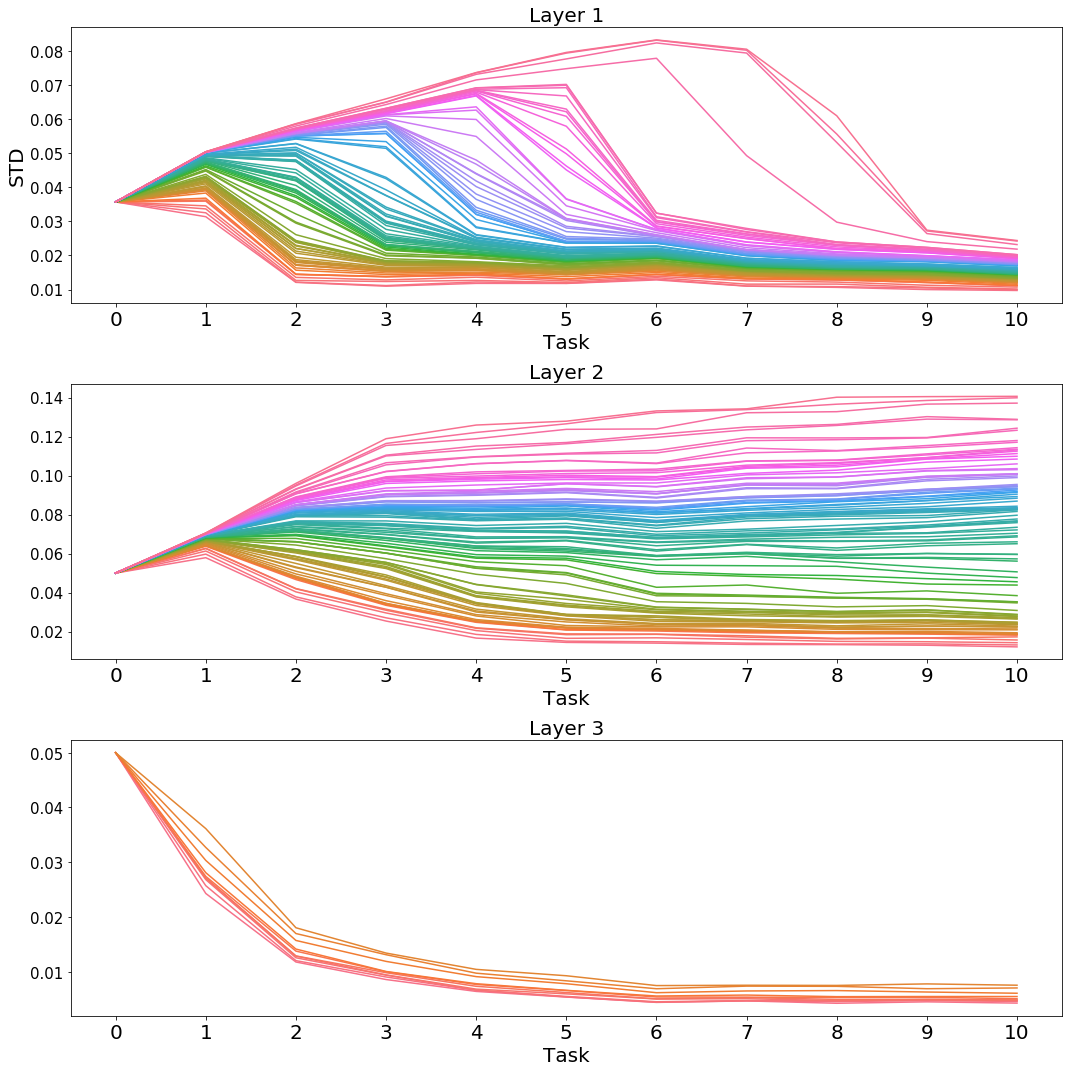

In [15]:
# name = '../models/trained_model/190725_ZERO_pmnist_baye_0_beta_0.0200000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_task_%d.pt'
# weight_node_wise_histogram(name, task_num=20)
name = '../models/trained_model/190725_ZERO_pmnist_baye_0_beta_0.0250000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_task_%d.pt'
weight_node_wise_histogram(name, task_num=10)
# name = '../models/trained_model/190725_ZERO_pmnist_baye_0_beta_0.0300000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_task_%d.pt'
# weight_node_wise_histogram(name, task_num=20)
# name = '../models/trained_model/190725_ZERO_pmnist_baye_0_beta_0.0350000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_task_%d.pt'
# weight_node_wise_histogram(name,task_num=10)
# name = '../models/trained_model/190725_ZERO_pmnist_baye_0_beta_0.0400000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_task_%d.pt'
# weight_node_wise_histogram(name,task_num=20)
# name = '../models/trained_model/190725_ZERO_pmnist_baye_0_beta_0.0450000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_task_%d.pt'
# weight_node_wise_histogram(name,task_num=20)
# name = '../models/trained_model/190725_ZERO_pmnist_baye_0_beta_0.0500000_FC_0.5000000_CNN_0.1250000_unitN_400_batch_256_epoch_100_task_%d.pt'
# weight_node_wise_histogram(name,task_num=20)

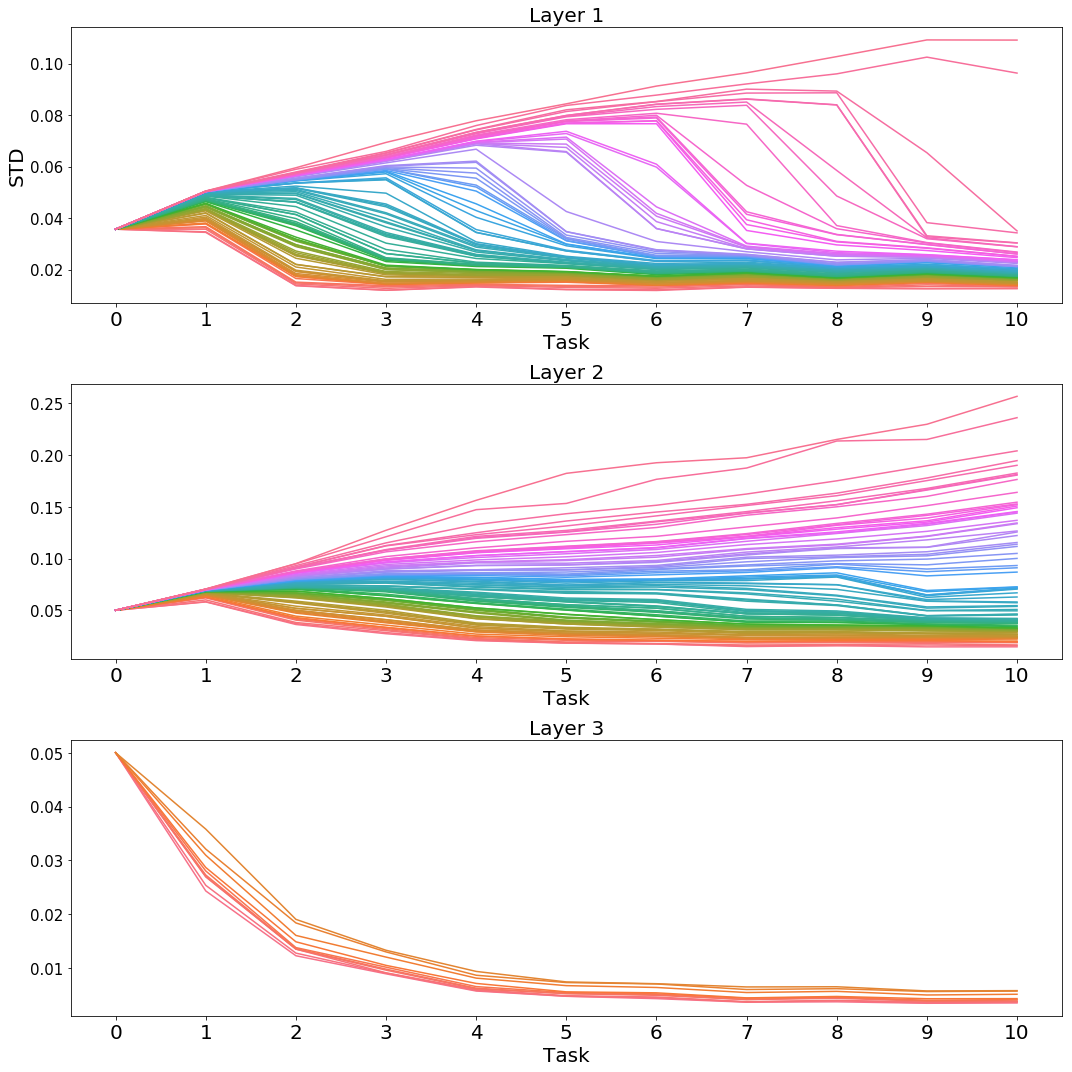

In [16]:
name = '../models/trained_model/TEST_pmnist_baye_0_beta_0.0250000_FC_0.5000000_CNN_0.2500000_lr_0.001_unitN_400_batch_256_epoch_100_task_%d.pt'
weight_node_wise_histogram(name, task_num=10)